# Working with global high-resolution data

A unique feature of xarray is it works well with very large data. This is crucial for global high-resolution models like [GCHP](http://wiki.seas.harvard.edu/geos-chem/index.php/GEOS-Chem_HP), which could produce GBs of data even for just one variable.  The data often exceed computer's memory, so IDL/MATLAB programs will just die if you try to read such large data.

## Lazy evaluation

Here we use a native resolution GEOS-FP metfield as an example. You can download it at:

    ftp://ftp.as.harvard.edu/gcgrid/GEOS_0.25x0.3125/GEOS_0.25x0.3125.d/GEOS_FP/2015/07/GEOSFP.20150701.A3cld.Native.nc

In [1]:
%%bash
du -h ./GEOSFP.20150701.A3cld.Native.nc

1.4G	./GEOSFP.20150701.A3cld.Native.nc


The file size is 1.4 GB -- not extremely large. But that's already after [NetCDF compression](http://www.unidata.ucar.edu/blogs/developer/entry/netcdf_compression)! The raw data size (after reading into memory) would be more than 20 GB, which exceeds most computers' memory.

Let's see how long it takes to read such a file with xarray

In [2]:
import xarray as xr
%time ds = xr.open_dataset("./GEOSFP.20150701.A3cld.Native.nc")

CPU times: user 19.8 ms, sys: 4.65 ms, total: 24.4 ms
Wall time: 25.9 ms


Wait, just milliseconds? 

It looks like we do get the entire file:

In [3]:
ds

<xarray.Dataset>
Dimensions:   (lat: 721, lev: 72, lon: 1152, time: 8)
Coordinates:
  * time      (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
  * lev       (lev) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * lat       (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon       (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...
Data variables:
    CLOUD     (time, lev, lat, lon) float64 0.1229 0.1229 0.1229 0.1229 ...
    OPTDEPTH  (time, lev, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    QCCU      (time, lev, lat, lon) float64 9.969e+36 9.969e+36 9.969e+36 ...
    QI        (time, lev, lat, lon) float64 8.382e-08 8.382e-08 8.382e-08 ...
    QL        (time, lev, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TAUCLI    (time, lev, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    TAUCLW    (time, lev, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    Title:              

But that's deceptive. xarray only reads the metadata such as dimensions, coordinates and attributes, so it is lightning fast. It will read the actual numerical data if you explicitly execute `ds.load()`. **Never** try this command on this kind of large data because your program will just die.

xarray will automatically retrieve the data from disk **only when** they are actually needed. In other words, it tries to keep the memory usage as low as possible. We call this **lazy evaluation**.

Any operation that doesn't require the actual data will be lightning fast. Such as selecting a variable:

In [4]:
dr = ds['CLOUD'] # super fast
dr

<xarray.DataArray 'CLOUD' (time: 8, lev: 72, lat: 721, lon: 1152)>
[478420992 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
  * lev      (lev) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...
Attributes:
    long_name:       Total cloud fraction in grid box
    units:           1
    gamap_category:  GMAO-3D$

Even for indexing or any other array operations: (as long as your don't explicitly ask for the data values)

In [5]:
dr_surf = dr.isel(lev=0) # super fast
dr_surf

<xarray.DataArray 'CLOUD' (time: 8, lat: 721, lon: 1152)>
[6644736 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
    lev      float32 1.0
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...
Attributes:
    long_name:       Total cloud fraction in grid box
    units:           1
    gamap_category:  GMAO-3D$

This `dr_surf` object points to the surface level of the *CLOUD* data. This subset of data is sufficiently small so we can read it into memory. Even reading a single level takes 2 seconds, so you can imagine how long it will take to read the full data. 

(Note that the NetCDF format allows you to only read a subset of data into memory)

In [6]:
%time dr_surf.load()

CPU times: user 1.87 s, sys: 132 ms, total: 2.01 s
Wall time: 2.01 s


<xarray.DataArray 'CLOUD' (time: 8, lat: 721, lon: 1152)>
array([[[ 0.122925,  0.122925, ...,  0.122925,  0.122925],
        [ 0.289062,  0.290039, ...,  0.287598,  0.288574],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 0.151123,  0.151123, ...,  0.151123,  0.151123],
        [ 0.27002 ,  0.269043, ...,  0.272461,  0.271484],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       ..., 
       [[ 0.211426,  0.211426, ...,  0.211426,  0.211426],
        [ 0.106689,  0.106567, ...,  0.106934,  0.106812],
        ..., 
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[ 0.548828,  0.548828, ...,  0.548828,  0.548828],
        [ 0.624023,  0.625   , ...,  0.623047,  0.623047],
        ..., 
        [ 0.      ,  0.      , ...,  0.  

Since the data is now in memory, we can plot it. In fact, you don't need to run `dr_surf.load()` before plotting. xarray will automatically read the data when you try to plot, because a plotting operation requires the actual data values.

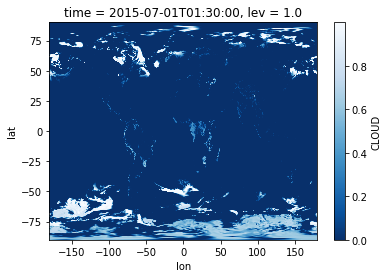

In [7]:
%matplotlib inline
dr_surf.isel(time=0).plot(cmap='Blues_r')

## More explanation on data size

So how much data is actually read into memory? Just 50 MB.

In [8]:
print(dr_surf.nbytes / 1e6, 'MB')

53.157888 MB


An equivalent calculation:

In [9]:
print(8*721*1152 * 8 / 1e6, 'MB') # ntime*nlon*nlat * 8 byte float

53.157888 MB


What's the size of the entire *CLOUD* data, with all 72 levels?

In [10]:
print(dr.nbytes / 1e9, 'GB')

3.827367936 GB


An equivalent calculation:

In [11]:
print(8*721*1152*72 * 8 / 1e9, 'GB') # ntime*nlon*nlat*nlev * 8 byte float

3.827367936 GB


Even if the memory is enough, reading such data will take very long!

Finally, what's the size of the entire NetCDF file?

In [12]:
print(ds.nbytes / 1e9, 'GB')

26.791583396 GB


Such size will kill almost all laptops. But thanks to lazy evaluation, we have no problem with it.

## Out-of-core data processing

Sometimes you do need to process the entire data (e.g. take global average), not just select a subset. Fortunately, xarray can still deal with it, thanks to the [out-of-core computing](https://en.wikipedia.org/wiki/Out-of-core_algorithm) technique.

We know our NetCDF data has 8 time slices, so let's divide it into 8 pieces so that a single piece would not exceed memory. 
(see [xarray documentation](http://xarray.pydata.org/en/stable/dask.html) for more about `chunk`)

In [13]:
ds = ds.chunk({'time': 1})

Now our `DataArray` has a new `chunksize` attribute:

In [14]:
dr = ds['CLOUD']
dr

<xarray.DataArray 'CLOUD' (time: 8, lev: 72, lat: 721, lon: 1152)>
dask.array<xarray-CLOUD, shape=(8, 72, 721, 1152), dtype=float64, chunksize=(1, 72, 721, 1152)>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
  * lev      (lev) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...
Attributes:
    long_name:       Total cloud fraction in grid box
    units:           1
    gamap_category:  GMAO-3D$

We want to take column average over the entire data field. The following command still uses lazy-evaluation without doing actual computation.

In [15]:
dr.mean(dim='lev')

<xarray.DataArray 'CLOUD' (time: 8, lat: 721, lon: 1152)>
dask.array<mean_agg-aggregate, shape=(8, 721, 1152), dtype=float64, chunksize=(1, 721, 1152)>
Coordinates:
  * time     (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...

Use `.compute()` when you actually need the results. Then xarray will process each piece ("chunk") one by one, and put the results together.

Because xarray uses
[dask](http://dask.pydata.org/en/latest/index.html) under the hood, we can use [dask ProgressBar](http://dask.pydata.org/en/latest/diagnostics.html#progress-bar) to monitor the progress. Otherwise it will look like getting stuck.

In [16]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    dr_levmean = dr.mean(dim='lev').compute()

[########################################] | 100% Completed | 17.9s


It takes 20 seconds, kind of time-consuming. But this calculation is not possible at all with traditional tools like IDL/MATLAB.

Now we see the actual numerical data:

In [17]:
dr_levmean

<xarray.DataArray 'CLOUD' (time: 8, lat: 721, lon: 1152)>
array([[[ 0.098929,  0.098929, ...,  0.098929,  0.098929],
        [ 0.116195,  0.116132, ...,  0.116353,  0.116277],
        ..., 
        [ 0.027914,  0.027806, ...,  0.028132,  0.028024],
        [ 0.02229 ,  0.02229 , ...,  0.02229 ,  0.02229 ]],

       [[ 0.103683,  0.103683, ...,  0.103683,  0.103683],
        [ 0.114203,  0.114143, ...,  0.11426 ,  0.114244],
        ..., 
        [ 0.026128,  0.026203, ...,  0.026008,  0.026071],
        [ 0.016974,  0.016974, ...,  0.016974,  0.016974]],

       ..., 
       [[ 0.07467 ,  0.07467 , ...,  0.07467 ,  0.07467 ],
        [ 0.072274,  0.072266, ...,  0.07231 ,  0.072309],
        ..., 
        [ 0.006045,  0.006052, ...,  0.00604 ,  0.006046],
        [ 0.008976,  0.008976, ...,  0.008976,  0.008976]],

       [[ 0.069148,  0.069148, ...,  0.069148,  0.069148],
        [ 0.070722,  0.070705, ...,  0.070723,  0.070725],
        ..., 
        [ 0.002394,  0.002377, ...,  0.00

You can use `dr_levmean.to_netcdf("filename.nc")` to save the result to disk. 

We can further simplify the above process. Instead of using `.compute()` to get in-memory result, we can simply do a "disk to disk" operation.

In [18]:
with ProgressBar():
    dr.mean(dim='lev').to_netcdf('column_average.nc')

[########################################] | 100% Completed | 19.4s


xarray automatically reads each piece (chunk) of data into memory, compute the mean, dump the result to disk, and proceed to the next piece.

Open the file to double check:

In [19]:
xr.open_dataset('column_average.nc')

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1152, time: 8)
Coordinates:
  * time     (time) datetime64[ns] 2015-07-01T01:30:00 2015-07-01T04:30:00 ...
  * lat      (lat) float32 -89.9375 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
  * lon      (lon) float32 -180.0 -179.688 -179.375 -179.062 -178.75 ...
Data variables:
    CLOUD    (time, lat, lon) float64 0.09893 0.09893 0.09893 0.09893 ...

## A compact version of previous section

All we've done in the previous section can be summarized by 2 lines of code:

In [20]:
ds = xr.open_dataset("./GEOSFP.20150701.A3cld.Native.nc", chunks={'time': 1})
ds['CLOUD'].mean(dim='lev').to_netcdf('column_average_CLOUD.nc')

That's it! You've just solved a geoscience big data problem without worrying about any specific "big data" techniques!